![University of Tehran](https://github.com/daniyalmaroufi/AI_Course/blob/main/CA5/img/UT.png?raw=1)
#   <font color='red'><center>AI CA 5 - Phase 1<center></font> 
## <center>Dr. Fadaei<center>
### <center>Daniyal Maroufi<center>
### <center>810098039<center>


## Aim

This assignment aims to implement a neural networks API from scratch and use it to train a model for classifying handwritten Persian numbers.


# Dataset

The dataset consists of 102353 handwritten Persian numbers of digits 0 to 9.

![Digits_Sample](https://github.com/daniyalmaroufi/AI_Course/blob/main/CA5/img/Digits_Sample.gif?raw=1)

# Part 1 - Preprocessing

In [93]:
import copy
import random
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
with open('data.pkl','rb') as f:
    data=pickle.load(f)
with open('labels.pkl','rb') as f:
    labels=pickle.load(f)


In [5]:
# https://github.com/amir-saniyan/HodaDatasetReader/blob/master/HodaDatasetReader.py
def resize_image(src_image, dst_image_height=25, dst_image_width=25):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

In [6]:
n_data=len(data)

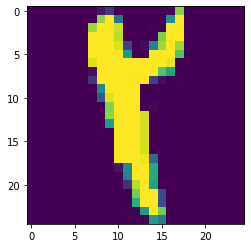

In [ ]:
img_idx=random.randint(0,n_data)
img=resize_image(data[img_idx])
plt.imshow(img)
plt.show()

In [7]:
for i in range(n_data):
    data[i]=resize_image(data[i]).flatten()


In [8]:
print('The value of each pixel is between',np.min(data[i]),'and',np.max(data[i]))

The value of each pixel is between 0 and 255


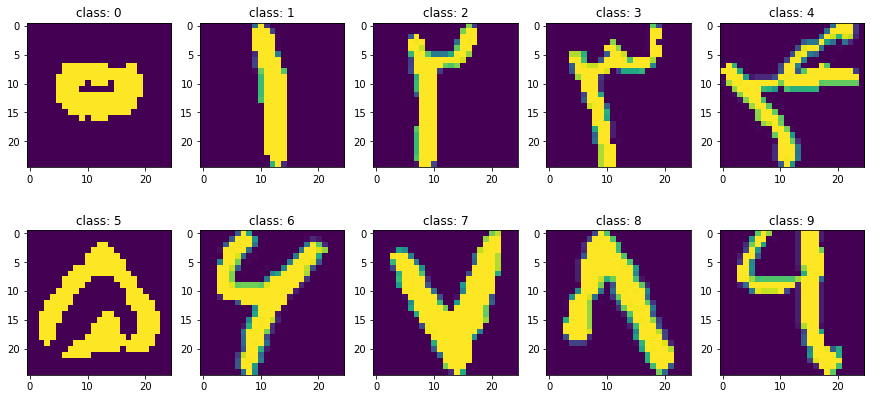

In [9]:
plt.figure(figsize=(15,7))
for class_idx in range(10):
    for i in range(n_data):
        if labels[i]==class_idx:
            plt.subplot(2,5,class_idx+1)
            plt.imshow(data[i].reshape(25,25))
            plt.title('class: '+str(class_idx))
            break

plt.show()

In [10]:
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)

In [11]:
train_classes_samples_count=defaultdict(lambda: 0)
test_classes_samples_count=defaultdict(lambda: 0)

for class_idx in y_train:
    train_classes_samples_count[class_idx]+=1

for class_idx in y_test:
    test_classes_samples_count[class_idx]+=1


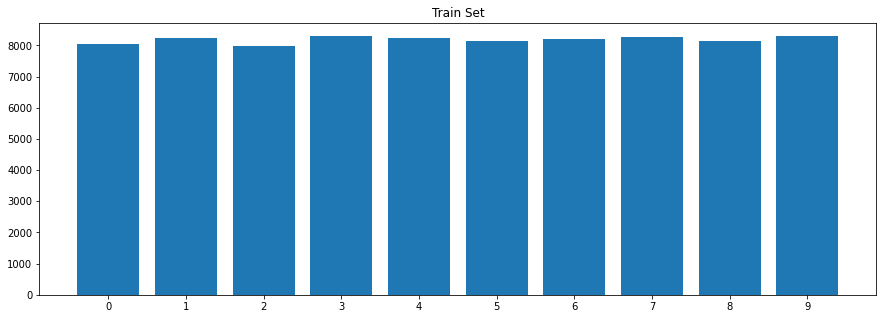

In [12]:
plt.figure(figsize=(15,5))
plt.bar(train_classes_samples_count.keys(),train_classes_samples_count.values())
plt.xticks([i for i in range(10)])
plt.title('Train Set')
plt.show()

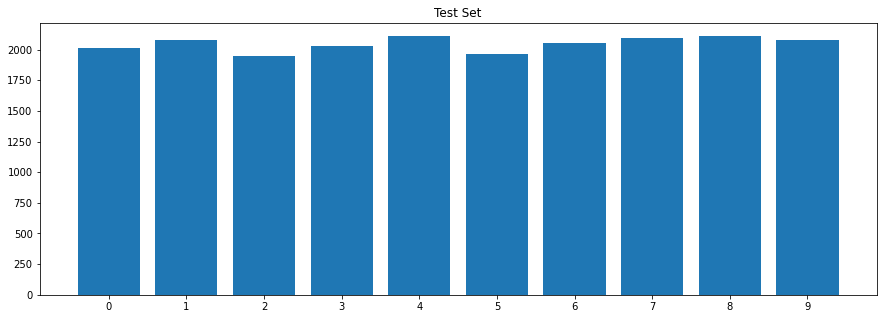

In [13]:
plt.figure(figsize=(15,5))
plt.bar(test_classes_samples_count.keys(),test_classes_samples_count.values())
plt.xticks([i for i in range(10)])
plt.title('Test Set')
plt.show()

## Scaling
The rescaling of inputs tries to keep the range of weights in a small range. Theoretically, it is not necessary to rescale the inputs because an appropriate redefinition of the weights can compensate for it. Practically it is important because the weights might occupy a very large range of values.

$x_{scaled}=\dfrac{x}{255}$

In [14]:
for i in range(len(x_train)):
    x_train[i]=x_train[i]/255

for i in range(len(x_test)):
    x_test[i]=x_test[i]/255


# Part 2 - Implementation

## Dataloader

In [15]:
class Dataloader:
    '''
    This class prepares the dataset for the neural network.
    '''
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        '''
        This is the constructor. It gets dataset information and initializes the 
        Dataloader class fields.
            Parameters:
                data: features your dataset in pandas.Dataframe format.
                labels: labels of your dataset in pandas.Dataframe format.
                n_classes: number of classes you have in your dataset.
                batch_size: the number of samples that will be propagated through the network.
                shuffle: boolean value indicating whether or not the dataset should be shuffled
        '''

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        '''
        This private method gets labels and provides one_hot vectors of labels.
        For categorical variables where no such ordinal relationship exists,
        the integer encoding is not enough.
        In this case, a one-hot encoding can be applied to the integer representation.
        This is where the integer encoded variable is removed, and a new binary variable is
        added for each unique integer value.
        example:
            red,    green,    blue
            1,      0,        0
            0,      1,        0
            0,      0,        1
                Parameters:
                        label: lables of your dataset in pandas.Dataframe format.
                        n_classes: number of classes you have in your dataset.
                
                Returns:
                    onehot_vectors: onehot vectors of the labels
        '''
        onehot_vectors_list = []
        for i in range(len(labels)):
            onehot_vectors_i = np.zeros(n_classes)
            classNum = labels[i]
            onehot_vectors_i[classNum] = 1
            onehot_vectors_list.append(onehot_vectors_i)
        onehot_vectors = np.array(onehot_vectors_list)
        return onehot_vectors
    
    def __shuffle_dataset(self):
        '''
        This private method shuffles your dataset.
        It uses data and onehot_labels to shuffle them
        symmetrical.
        '''
        self.__data, self.__onehot_labels = shuffle(self.__data, self.__onehot_labels, random_state=0)
    
    def __iter__(self):
        '''
        The __iter__() function returns an iterator for the
        given object (array, set, tuple, etc., or custom objects).
        This will return your dataset in the batch_size given. This should
        be used to provide data for the neural network.
        '''

        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))


## Activation Functions

In [16]:
class Identical:
    '''
    This is the Identical activation function. This activation function just
    return the value it gets.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        As this is an identical activity function, it just 
        returns np.matrix of the input.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_value: np.matrix of input with float datatypes
        '''
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        '''
        This method returns the derivation of the input.
        As the derivation of x is one, this method returns
        a matrix of one with the shape of the input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_derivative: np.matrix of ones with matrix shape
        '''
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _value method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    

class Relu:
    '''
    This is the Relu activation function. 
    The rectified linear activation function or ReLU for short
    is a piecewise linear function that will output the input directly
    if it is positive, otherwise, it will output zero.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set 0 in the matrix if the value is less than 0 else, it returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        relu_value = np.array(matrix, dtype=float)
        relu_value = np.maximum(relu_value, 0)
        return relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_derivative: np.matrix of relu activation function derivation result
        '''
        relu_derivative = np.array(matrix, dtype=float)
        relu_derivative = np.where(relu_derivative > 0, 1, 0)
        return relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _relu method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __relu(matrix): __relu return value for the input matrix
        '''
        return self.__val(matrix)

    
class LeakyRelu:
    '''
    This is the Leaky Relu activation function. 
    Leaky Rectified Linear Unit, or Leaky ReLU,
    is a type of activation function based on a ReLU,
    but it has a small slope for negative values instead
    of a flat slope.
    '''
    
    def __init__(self, negative_slope=0.01):
        '''
        This is the constructor.
        It sets negative_slope field.
            Parameters:
                negative_slope: slope for negative input values
        '''
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set negative_slope*value in the matrix if the value is less than 0, else it
        returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        leacky_relu_value = np.array(matrix, dtype=float)
        leacky_relu_value = np.where(leacky_relu_value > 0, leacky_relu_value, leacky_relu_value* 0.01)     
        return leacky_relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of leaky relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                leacky_relu_derivative: np.matrix of leaky relu activation function derivation result
        '''
        leacky_relu_derivative = np.array(matrix, dtype=float)
        leacky_relu_derivative = np.where(leacky_relu_derivative > 0, 1, self.negative_slope)
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

    
class Sigmoid:
    '''
    A sigmoid function is a mathematical function having a
    characteristic "S"-shaped curve or sigmoid curve.
    It return S(x)=1/(1+e^-x)
    '''
    
    def __init__(self): pass

    def __val(self, matrix):
        '''
        Returns 1/(1+e^-x) of values
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_value: np.matrix of relu activation function result
        '''
        sigmoid_value = np.array(matrix, dtype=float)
        sigmoid_value = 1/(1+np.exp(-sigmoid_value))
        return sigmoid_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of sigmoid function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of sigmoid activation function derivation result
        '''
        sigmoid_derivative = np.array(matrix, dtype=float)
        sigmoid_derivative = (1/(1+np.exp(-sigmoid_derivative)))*(1-(1/(1+np.exp(-sigmoid_derivative))))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)


class Softmax:
    '''
    The softmax function, also known as softargmax  or normalized
    exponential function is a generalization of the logistic
    function to multiple dimensions. It is used in multinomial logistic
    regression and is often used as the last activation function of a neural
    network to normalize the output of a network to a probability distribution
    over predicted output classes, based on Luce's choice axiom.
    Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
    '''
        
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the softmax on that.
        Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        softmax_value = np.array(matrix, dtype=float)
        for i in range(softmax_value.shape[0]):
          max = np.max(softmax_value[i])
          num = np.exp(np.subtract(softmax_value[i], max))
          den = np.sum(num)
          softmax_value[i] = np.divide(num, den)
        return np.clip(softmax_value,1e-37,1)
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    
class Tanh:
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It performs Tanh on the values.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                tanh_value: np.matrix of Tanh activation function result
        '''
        tanh_value = np.array(matrix, dtype=float)
        tanh_value = np.tanh(tanh_value)
        return tanh_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of Tanh function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of Tanh activation function derivation result
        '''
        tanh_derivative = np.array(matrix, dtype=float)
        tanh_derivative = (1-(np.tanh(tanh_derivative))*(np.tanh(tanh_derivative)))
        return tanh_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

## Loss Function

In [17]:
class CrossEntropy:
    '''
    Cross-entropy is a measure of the difference between two probability
    distributions for a given random variable or set of events. You might
    recall that information quantifies the number of bits required to encode
    and transmit an event.
    The above image can help you.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, true_val, expected_val):
        '''
        L(y^, y) = - Σ (y^(k)log (y^)^(k)) for k in K
        Parameters:
            true_val: calculated values (generated by neural network)
            expected_val: real values in dataset
        Returns:
            cross_entropy_value: cross entropy of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        cross_entropy_value = -1*np.sum(np.multiply(expected_val, np.log10(true_val)))
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        '''
        Returns derivation of cross entropy.
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                cross_entropy_derivative: cross entropy derivation of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        cross_entropy_derivative = true_val - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(true_val, expected_val)

## Layer

In [18]:
class Layer:
    '''
    The layer class is used to define neural network layers.
    It stores all needed information for each layer, such as neurons count,
    weight matrix, bias, the output after applying the activation function, etc.
    '''

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        '''
        Parameters:
            input_size: the size of the input of this layer.
            output_size: the size of the output after this layer.
            activation: the activation function. It can be initialized to either of the previously defined activation classes.
                               default is an Identical activation function.
            initial_weight: either normal or uniform. It defines the method for weight initialization.
        '''
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        '''
        It calculates the output of this layer for the layer_input argument.
        This method also stores __last_input, __last_activation_input, and __last_activation_derivative
        for future use in backpropagation.
        Parameters:
            layer_input: 2d np.matrix representing the input matrix of this layer.
        Returns:
            Final output of this layer after applying the activation function.
        '''
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)

        self.__last_input = layer_input
        self.__last_activation_input = np.dot(layer_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_output)

        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        '''
        It updates Layer weights according to the backpropagation matrix and learning rate.
        This method updates bias values as well.
        Parameters:
            backprop_tensor: 2d np.matrix passed from the next layer containing gradient values.
            lr: learning rate
        Returns:
            backprop_tensor to be used by the previous layer.
        '''
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons

        self.__weight -= lr * np.dot(np.transpose(self.__last_input), 
                                np.array(backprop_tensor)*
                                np.array(self.__last_activation_derivative))
        self.__bias -= lr * np.array(backprop_tensor) * np.array(self.__last_activation_derivative)
        backprop_tensor = np.dot(np.array(backprop_tensor)*np.array(self.__last_activation_derivative), np.transpose(self.__weight))

        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a uniform distribution between low and high values.
        It uses default low and high values unless low or high are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom low or high values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using uniformly distributed values.
        '''
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']

        weights = np.random.uniform(low=low, high=high, size=(dim1, dim2))

        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a normal distribution with mean and var values.
        It uses default mean and variance values unless mean or var are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom mean or var values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using normaly distributed values.
        ''' 
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']

        weights = np.random.normal(loc=mean, scale=var, size=(dim1, dim2))

        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    @n_neurons.setter
    def n_neurons(self, num_neurons):
        self.__n_neurons = num_neurons
    
    @property
    def weight(self): return self.__weight
    @weight.setter
    def weight(self, weight_new): 
        self.__weight = weight_new
    
    @property
    def bias(self): return self.__bias
    @bias.setter
    def bias(self, bias_new): 
        self.__bias = bias_new
    
    @property
    def activation(self): return self.__activation
    @activation.setter
    def activation(self, activation_new): 
        self.__activation = activation_new


## Feed Forward Neural Network

In [19]:
class FeedForwardNN:
    '''
    This class is used in order to implement custom feed-forward neural networks.
    The FeedForwardNN class stores a list of layers that determines all network layers.
    It also consists of the learning rate and loss function.
    '''
    def __init__(self, input_shape):
        '''
        Parameters:
            input_shape: the size of the first input to our neural network.
        '''
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        '''
         This method adds a new custom layer to the layers_list.
         Parameters:
             n_neurons: number of neurons in this layer
             activation: the activation function of this layer, default is Relu
             initial_weight: either a uniform or normal, default is uniform
             initializing_parameters: other initializing parameters such as low, high, mean, var, etc
        '''
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        '''
        This method is used to set training parameters.
        Parameters:
            loss: loss function, default is CrossEntropy
            lr: learning rate, default is 1e-3
        '''
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        '''
        This method calculates the output of the complete neural network for a passed input.
        Parameters:
            network_input: input of the neural network
        Returns:
            network_output: output of the neural network after forwarding the network_input
        '''
        assert type(self.__output_shape) != None, "Model is not compiled!"

        outputOfLayer = network_input

        for layer in self.__layers_list:
            outputOfLayer = layer.forward(outputOfLayer)

        softmax = Softmax()

        network_output = softmax(outputOfLayer)

        return network_output


    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        '''
        This method trains the neural network using specified parameters.
        It runs the __train private method epoch times and fills the log dictionary.
        Parameters:
            epochs: number of epochs to run
            trainloader: DataLoader for train data
            testloader: DataLoader for test data
            print_results: whether or not to print the results
        Returns:
            log: complete log of the training process as a dictionary consisting of
            train_accuracy, train_loss, test_accuracy, test_loss
        '''
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}

        for epoch in range(1, epochs+1):

            if print_results: 
                print('Epoch {}:'.format(epoch)) 

            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))

            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))

        return log


    def __train(self, trainloader):
        '''
        Trains the neural network for one epoch.
        Parameters:
            trainloader: A DataLoader consisting of train data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)


    def __test(self, testloader):
        '''
        Test the neural network using a testloader.
        Parameters:
            testloader: A DataLoader of test data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)


    def __train_on_batch(self, x_batch, y_batch):
        '''
        Trains the neural network for one batch of train data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''

        layers = copy.deepcopy(self.__layers_list)
        batch_size = len(x_batch)
        weight = []

        for x,y in zip(x_batch, y_batch):
            predicted_out = self.forward(x)
            if(len(weight) != 0):
                for i in range(len(self.__layers_list)):
                    self.__layers_list[i].weight = weight[i]
                    self.__layers_list[i].bias = bias[i]
            self.__update_weights(predicted_out, y)

            weight = []
            bias = []
            for layer in self.__layers_list:
                weight.append(layer.weight)
                bias.append(layer.bias)

            batch_size -= 1
            if(batch_size != 0):
                self.__layers_list = copy.deepcopy(layers)

        predicted_out_list = []
        for i in range(len(y_batch)):
            predicted_out_list.append(self.forward(x_batch[i]))

        batch_accuracy = self.__compute_accuracy(predicted_out_list, y_batch)
        batch_average_loss = 0

        for i in range(len(y_batch)):
            batch_average_loss = self.__loss(predicted_out_list[i], y_batch[i])
        batch_average_loss = batch_average_loss/(len(y_batch))

        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        '''
        Tests the neural network for one batch of test data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''

        predicted_out_list = []
        for i in range(len(y_batch)):
            predicted_out_list.append(self.forward(x_batch[i]))
        batch_accuracy = self.__compute_accuracy(predicted_out_list, y_batch)

        batch_average_loss_list = []
        for i in range(len(y_batch)):
            batch_average_loss_list.append(self.__loss(predicted_out_list[i], y_batch[i]))
        batch_average_loss=np.sum(batch_average_loss_list)/len(y_batch)

        return (batch_accuracy, batch_average_loss)


    def __get_labels(self, outputs):
        '''
        Parameters:
            outputs: output of the neural network
        Returns:
            labels: labels generated from the outputs of the neural network
        '''

        labels = np.zeros(len(outputs))
        for i in range(len(outputs)):
            labels[i] = np.argmax(outputs[i])

        return labels


    def __compute_accuracy(self, output, expected_output):
        '''
        Computes accuracy by comparing output and expected_output.
        Parameters:
            output: actual output of the neural network
            expected_output: expected output
        Returns:
            accuracy
        '''
        accuracy = 0
        for i in range(len(output)):
            if(np.argmax(output[i]) == np.argmax(expected_output[i])):
                accuracy += 1
        accuracy = accuracy/len(output)
        return accuracy


    def __update_weights(self, output, y_train):
        '''
        Updates weights of all layers according to neural network output and labels.
        Parameters:
            output: output of the neural network
            y_train: y labels for one batch of train data
        Returns:
            None
        '''

        backprop_tensor = self.__loss.derivative(output, y_train)
        for layer_i_idx in range(len(self.__layers_list)-1, -1, -1):
            backprop_tensor = self.__layers_list[layer_i_idx].update_weights(backprop_tensor, self.__lr)   

        return

# Part 3 - Using on the Dataset

## Training Sample Code

In [20]:
# Sample code for building and training a model

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=32)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:
	Train: Average Accuracy: 0.9015294060179758	Average Loss: 0.004618265355026226
	Test: Average Accuracy: 0.9471000339673914	Average Loss: 0.08464395042131909
Epoch 2:
	Train: Average Accuracy: 0.9675830402500977	Average Loss: 0.0016842536548152727
	Test: Average Accuracy: 0.9524222995923914	Average Loss: 0.07681634420021126
Epoch 3:
	Train: Average Accuracy: 0.9728985932004689	Average Loss: 0.0014747180963425534
	Test: Average Accuracy: 0.9544242527173914	Average Loss: 0.07248837400722166
Epoch 4:
	Train: Average Accuracy: 0.9756340367330989	Average Loss: 0.0013633139673824037
	Test: Average Accuracy: 0.9560844089673914	Average Loss: 0.07034364866304572
Epoch 5:
	Train: Average Accuracy: 0.9781008206330598	Average Loss: 0.0012728035218599904
	Test: Average Accuracy: 0.9571097995923914	Average Loss: 0.06927756059647068
Epoch 6:
	Train: Average Accuracy: 0.979944802657288	Average Loss: 0.0011728404495762808
	Test: Average Accuracy: 0.9573539402173914	Average Loss: 0.069614965579

In [100]:
log

{'test_accuracy': [0.9471000339673914,
  0.9524222995923914,
  0.9544242527173914,
  0.9560844089673914,
  0.9571097995923914,
  0.9573539402173914,
  0.9567191745923914,
  0.9552543308423914,
  0.9525199558423914,
  0.9494437839673914,
  0.9481742527173914,
  0.9470023777173914,
  0.9518363620923914,
  0.9565238620923914,
  0.9579398777173914],
 'test_loss': [0.08464395042131909,
  0.07681634420021126,
  0.07248837400722166,
  0.07034364866304572,
  0.06927756059647068,
  0.06961496557980065,
  0.070354679623355,
  0.0734402760930647,
  0.0802176854558406,
  0.08969518204942772,
  0.0986839800548808,
  0.10932840106778255,
  0.109126364213511,
  0.10161397900766796,
  0.1014727163510695],
 'train_accuracy': [0.9015294060179758,
  0.9675830402500977,
  0.9728985932004689,
  0.9756340367330989,
  0.9781008206330598,
  0.979944802657288,
  0.9811537710042986,
  0.9816300312622118,
  0.9809183274716686,
  0.9791354044548652,
  0.9774379640484565,
  0.9734691285658461,
  0.9662153184837827

In [109]:
def plot_log(log,plot_loss=True):
    if plot_loss:
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
    plt.plot(log['train_accuracy'],label='train_accuracy')
    plt.plot(log['test_accuracy'],label='test_accuracy')
    plt.legend()
    plt.xlabel('Epochs')

    if plot_loss:
        plt.subplot(1,2,2)
        plt.plot(log['train_loss'],label='train_loss')
        plt.plot(log['test_loss'],label='test_loss')
        plt.legend()
        plt.xlabel('Epochs')
    plt.show()


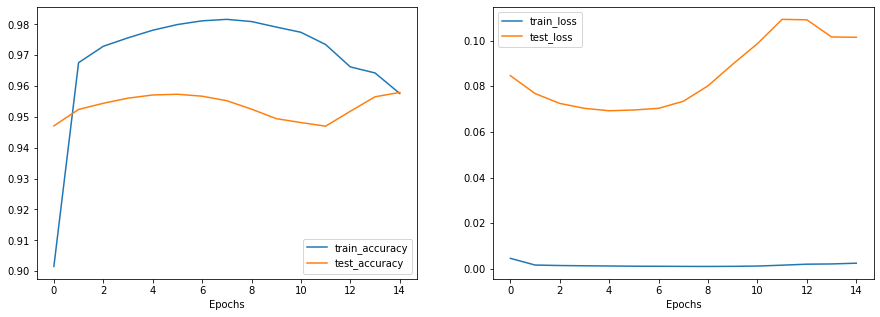

In [110]:
plot_log(log)

## Zero Initialization of Weights

Initializing the weights with zero or any other constant value causes neurons to perform the same calculation in each iteration and produces the same outputs. Also, the derivatives will remain the same for every w in W[layer]. As a result, neurons will learn the same features in each iteration. This problem is known as a network failing to break the symmetry. And not only zero, but any constant initialization will also produce a poor result.

## Learning Rate

In [23]:
# LR*10

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001*10
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=32)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

log

Epoch 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in subtract


	Train: Average Accuracy: 0.10222840953497458	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 2:
	Train: Average Accuracy: 0.09843053927315357	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 3:
	Train: Average Accuracy: 0.09843053927315357	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 4:
	Train: Average Accuracy: 0.09843053927315357	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 5:
	Train: Average Accuracy: 0.09843053927315357	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 6:
	Train: Average Accuracy: 0.09843053927315357	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 7:
	Train: Average Accuracy: 0.09843053927315357	Average Loss: nan
	Test: Average Accuracy: 0.09818274456521739	Average Loss: nan
Epoch 8:
	Train: Average Accuracy: 0.09843053927315357	Av

{'test_accuracy': [0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739,
  0.09818274456521739],
 'test_loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'train_accuracy': [0.10222840953497458,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357,
  0.09843053927315357],
 'train_loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan]}

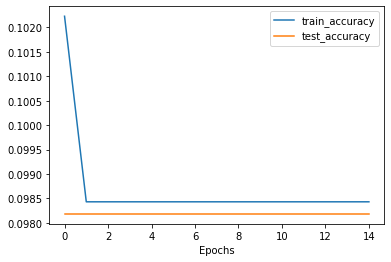

In [112]:
plot_log(log,False)

In [24]:
# LR*0.1

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001*0.1
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=32)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

log

Epoch 1:
	Train: Average Accuracy: 0.4957595740523642	Average Loss: 0.02161878665069148
	Test: Average Accuracy: 0.8158118206521738	Average Loss: 0.30973634807690864
Epoch 2:
	Train: Average Accuracy: 0.8671517194216491	Average Loss: 0.006554543417139076
	Test: Average Accuracy: 0.8966796875	Average Loss: 0.16126918790438055
Epoch 3:
	Train: Average Accuracy: 0.9107390582258695	Average Loss: 0.004195551526242632
	Test: Average Accuracy: 0.9203910495923914	Average Loss: 0.12381433242720097
Epoch 4:
	Train: Average Accuracy: 0.927176143024619	Average Loss: 0.0033914920337804943
	Test: Average Accuracy: 0.9313285495923914	Average Loss: 0.10762471182790585
Epoch 5:
	Train: Average Accuracy: 0.935602286049238	Average Loss: 0.0029920866067424407
	Test: Average Accuracy: 0.9381156589673914	Average Loss: 0.09845925295512788
Epoch 6:
	Train: Average Accuracy: 0.940780089878859	Average Loss: 0.0027494497330684017
	Test: Average Accuracy: 0.9422660495923914	Average Loss: 0.09247989090445478
Epoch

{'test_accuracy': [0.8158118206521738,
  0.8966796875,
  0.9203910495923914,
  0.9313285495923914,
  0.9381156589673914,
  0.9422660495923914,
  0.9459281589673914,
  0.9480765964673914,
  0.9492484714673914,
  0.9504691745923914,
  0.9519340183423914,
  0.9528617527173914,
  0.9540336277173914,
  0.9547172214673914,
  0.9557426120923914],
 'test_loss': [0.30973634807690864,
  0.16126918790438055,
  0.12381433242720097,
  0.10762471182790585,
  0.09845925295512788,
  0.09247989090445478,
  0.08824564660942803,
  0.08510737602568674,
  0.08266683456896376,
  0.08070963287299456,
  0.07908246532808709,
  0.07770241501171886,
  0.0765057366191876,
  0.07546240533235389,
  0.07453364228956916],
 'train_accuracy': [0.4957595740523642,
  0.8671517194216491,
  0.9107390582258695,
  0.927176143024619,
  0.935602286049238,
  0.940780089878859,
  0.9443459359124659,
  0.9468806174286831,
  0.9490421062915202,
  0.9509837827276281,
  0.9519607268464244,
  0.9533074443141852,
  0.9541989058225869,

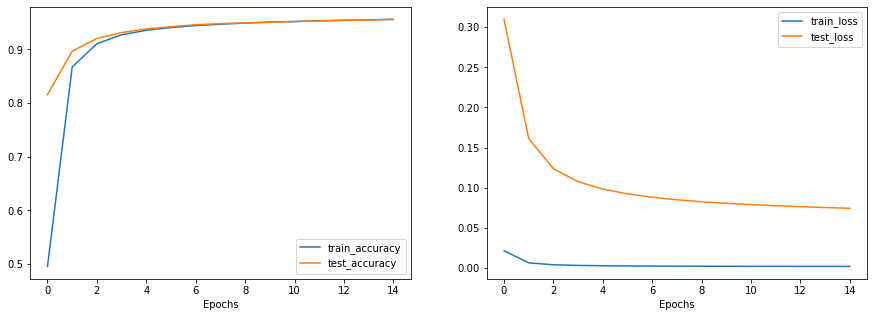

In [114]:
plot_log(log)

A large learning rate allows the model to learn faster, at the cost of arriving at a suboptimal final set of weights.
A small learning rate may allow the model to learn a more optimal or globally optimal set of weights but may take significantly longer to train (and may not converge). Also, for small values of the learning rate, vanishing gradients may occur.

For the rest of the assignment, we use the learning rate of 0.001 as it has better performance.

## Activation Function

In [25]:
# Sigmoid

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=32)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=Sigmoid(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

log

Epoch 1:
	Train: Average Accuracy: 0.10612397420867525	Average Loss: 0.031245352592791088
	Test: Average Accuracy: 0.10230341372282607	Average Loss: 0.9989786597094044
Epoch 2:
	Train: Average Accuracy: 0.1289146150840172	Average Loss: 0.031063862053016655
	Test: Average Accuracy: 0.20067085597826084	Average Loss: 0.9798926864622184
Epoch 3:
	Train: Average Accuracy: 0.36987397420867524	Average Loss: 0.029493302515914883
	Test: Average Accuracy: 0.4737156080163043	Average Loss: 0.9035429740594072
Epoch 4:
	Train: Average Accuracy: 0.4884574052364205	Average Loss: 0.027294821729530072
	Test: Average Accuracy: 0.5060780400815217	Average Loss: 0.8518749440997159
Epoch 5:
	Train: Average Accuracy: 0.5293058812035952	Average Loss: 0.02617536415798657
	Test: Average Accuracy: 0.5482655400815217	Average Loss: 0.8258389950234338
Epoch 6:
	Train: Average Accuracy: 0.5473026572880032	Average Loss: 0.025600261565395837
	Test: Average Accuracy: 0.5500233525815217	Average Loss: 0.8139799531252297
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:192: RuntimeWarning: overflow encountered in exp


	Train: Average Accuracy: 0.5514756740914419	Average Loss: 0.025041465036363772
	Test: Average Accuracy: 0.5512822690217392	Average Loss: 0.7988965436628568
Epoch 10:
	Train: Average Accuracy: 0.5444450957405237	Average Loss: 0.02497823092408164
	Test: Average Accuracy: 0.5451108186141305	Average Loss: 0.7967693569424099
Epoch 11:
	Train: Average Accuracy: 0.539194021101993	Average Loss: 0.024907033422799933
	Test: Average Accuracy: 0.5398862092391304	Average Loss: 0.7953044816807524
Epoch 12:
	Train: Average Accuracy: 0.5353595154357171	Average Loss: 0.0248668545149981
	Test: Average Accuracy: 0.5347592561141304	Average Loss: 0.7942485979017444
Epoch 13:
	Train: Average Accuracy: 0.5311552364204767	Average Loss: 0.02485008211556772
	Test: Average Accuracy: 0.5337338654891305	Average Loss: 0.7934355391441288
Epoch 14:
	Train: Average Accuracy: 0.5307033997655334	Average Loss: 0.024826301177651788
	Test: Average Accuracy: 0.5313901154891305	Average Loss: 0.7928229067089306
Epoch 15:
	Tr

{'test_accuracy': [0.10230341372282607,
  0.20067085597826084,
  0.4737156080163043,
  0.5060780400815217,
  0.5482655400815217,
  0.5500233525815217,
  0.5599057404891304,
  0.5592412533967391,
  0.5512822690217392,
  0.5451108186141305,
  0.5398862092391304,
  0.5347592561141304,
  0.5337338654891305,
  0.5313901154891305,
  0.5307065217391305],
 'test_loss': [0.9989786597094044,
  0.9798926864622184,
  0.9035429740594072,
  0.8518749440997159,
  0.8258389950234338,
  0.8139799531252297,
  0.8069388167868213,
  0.8022017816197066,
  0.7988965436628568,
  0.7967693569424099,
  0.7953044816807524,
  0.7942485979017444,
  0.7934355391441288,
  0.7928229067089306,
  0.7922763045094989],
 'train_accuracy': [0.10612397420867525,
  0.1289146150840172,
  0.36987397420867524,
  0.4884574052364205,
  0.5293058812035952,
  0.5473026572880032,
  0.5531853262993357,
  0.5565435717076983,
  0.5514756740914419,
  0.5444450957405237,
  0.539194021101993,
  0.5353595154357171,
  0.5311552364204767,
 

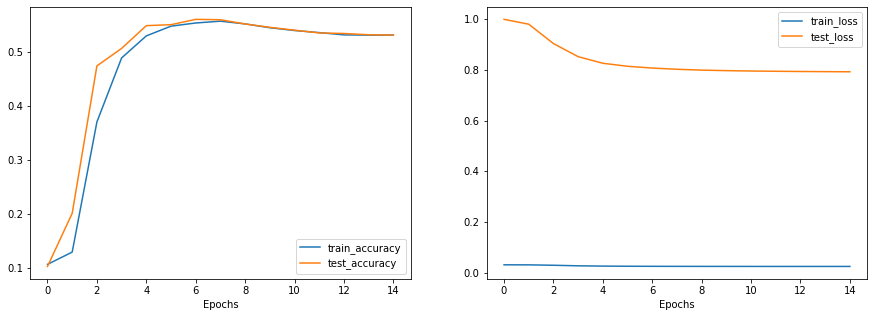

In [116]:
plot_log(log)

In [26]:
# Tanh

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=32)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=32)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=Tanh(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=Tanh(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

log

Epoch 1:
	Train: Average Accuracy: 0.4205680930050801	Average Loss: 0.024740797462276937
	Test: Average Accuracy: 0.7667098335597826	Average Loss: 0.5224905533661445
Epoch 2:
	Train: Average Accuracy: 0.7625107463853067	Average Loss: 0.015965168867513844
	Test: Average Accuracy: 0.7401091202445652	Average Loss: 0.5231223889082643
Epoch 3:
	Train: Average Accuracy: 0.7187368112543963	Average Loss: 0.01677293867003784
	Test: Average Accuracy: 0.7028638756793478	Average Loss: 0.5496463669124286
Epoch 4:
	Train: Average Accuracy: 0.687650937866354	Average Loss: 0.017415589288869087
	Test: Average Accuracy: 0.6798658288043479	Average Loss: 0.5642721006765851
Epoch 5:
	Train: Average Accuracy: 0.6701270027354436	Average Loss: 0.01792323083053728
	Test: Average Accuracy: 0.6664380944293479	Average Loss: 0.5788570992363621
Epoch 6:
	Train: Average Accuracy: 0.6588432981633451	Average Loss: 0.0183322110450051
	Test: Average Accuracy: 0.6604322350543479	Average Loss: 0.591178013890252
Epoch 7:
	

{'test_accuracy': [0.7667098335597826,
  0.7401091202445652,
  0.7028638756793478,
  0.6798658288043479,
  0.6664380944293479,
  0.6604322350543479,
  0.6128545346467391,
  0.5292034646739131,
  0.5154636548913043,
  0.4732570482336957,
  0.4714992357336957,
  0.5424740998641304,
  0.5336850373641304,
  0.5229916779891305,
  0.5154233186141305],
 'test_loss': [0.5224905533661445,
  0.5231223889082643,
  0.5496463669124286,
  0.5642721006765851,
  0.5788570992363621,
  0.591178013890252,
  0.597569166965752,
  0.6038613074147043,
  0.6103307245985201,
  0.6176564696509297,
  0.6236502425553748,
  0.6262068005573769,
  0.6266083050503658,
  0.6295000120829086,
  0.6215480320213741],
 'train_accuracy': [0.4205680930050801,
  0.7625107463853067,
  0.7187368112543963,
  0.687650937866354,
  0.6701270027354436,
  0.6588432981633451,
  0.6212797967956233,
  0.558361176240719,
  0.5225928096912856,
  0.5037187377881985,
  0.4743127198124268,
  0.47964048456428293,
  0.5409437280187573,
  0.529

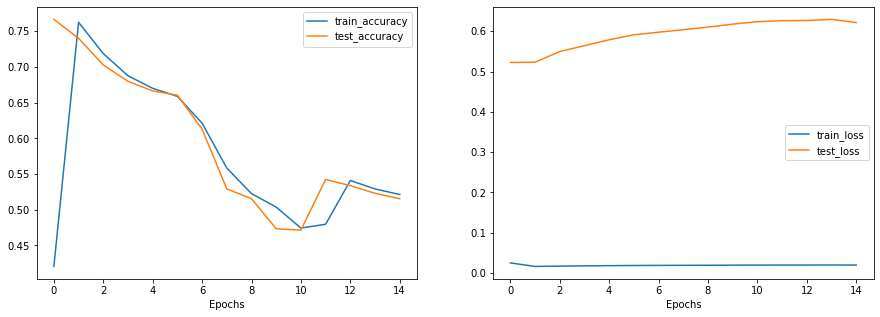

In [118]:
plot_log(log)

## Activation Function

### Sigmoid

1. The change is too slow when the activation function is close to the saturation region. The derivative needs the product of the previous derivative of each layer, and several smaller numbers are multiplied. The derivative result is very close to 0, so the training of the deep network cannot be completed.
2. The output of the Sigmoid is not zero-centered: this causes the input of neurons in the back layer to be a non-zero mean signal, which affects the gradient. Taking f = sigmoid(wx+b) as an example, assuming that the inputs are all positive (or negative), then the derivative of w is always positive (or negative) so that both are updated in the forward direction during backpropagation. Either they are all updated negatively, resulting in a binding effect that slows convergence.
3. Power operation is relatively time-consuming

### Tanh
In fact tanh(x)=2sigmoid(2x)-1. The tanh function compresses the input value to a range of -1 to 1, so it is zero-mean, which solves the non-zero-centered problem of the sigmoid function. Still, it has the problem of gradient disappearance and power operation.


### Leaky ReLU

With a Leaky ReLU, we won't face the "dead ReLU" problem, which happens when ReLU is always zero for values less than zero. This blocks learning in the ReLU because of zero gradients in the negative part. So the derivative of the LReLU is one for positive values and is a small fraction for negative values.


For the rest of the assignment, we use the Leaky ReLU activation function as it has better performance.


## Batch Size

In [27]:
# Batch Size: 16

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001*0.1
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=16)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=16)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

log

Epoch 1:
	Train: Average Accuracy: 0.4803376427423907	Average Loss: 0.044250160000850414
	Test: Average Accuracy: 0.8153041294642858	Average Loss: 0.3213241516085824
Epoch 2:
	Train: Average Accuracy: 0.8701939776822543	Average Loss: 0.013082342044932107
	Test: Average Accuracy: 0.8974609375	Average Loss: 0.16115000114174927
Epoch 3:
	Train: Average Accuracy: 0.9118457188137727	Average Loss: 0.008443017200640335
	Test: Average Accuracy: 0.92119140625	Average Loss: 0.12360174639192363
Epoch 4:
	Train: Average Accuracy: 0.9276477899353045	Average Loss: 0.006944290193463017
	Test: Average Accuracy: 0.93154296875	Average Loss: 0.10735763785912016
Epoch 5:
	Train: Average Accuracy: 0.9357320025183448	Average Loss: 0.006196829362051895
	Test: Average Accuracy: 0.93857421875	Average Loss: 0.09821547260876959
Epoch 6:
	Train: Average Accuracy: 0.9407266293256914	Average Loss: 0.005743455865630497
	Test: Average Accuracy: 0.942333984375	Average Loss: 0.0922700973231357
Epoch 7:
	Train: Average 

{'test_accuracy': [0.8153041294642858,
  0.8974609375,
  0.92119140625,
  0.93154296875,
  0.93857421875,
  0.942333984375,
  0.94541015625,
  0.947509765625,
  0.94921875,
  0.951123046875,
  0.951904296875,
  0.95302734375,
  0.95390625,
  0.95458984375,
  0.955322265625],
 'test_loss': [0.3213241516085824,
  0.16115000114174927,
  0.12360174639192363,
  0.10735763785912016,
  0.09821547260876959,
  0.0922700973231357,
  0.08808753549310075,
  0.08498282848471794,
  0.08255461949093099,
  0.08060055124545246,
  0.07898198680085947,
  0.07761561063491676,
  0.07643802419143433,
  0.07540909793870548,
  0.07449619230095869],
 'train_accuracy': [0.4803376427423907,
  0.8701939776822543,
  0.9118457188137727,
  0.9276477899353045,
  0.9357320025183448,
  0.9407266293256914,
  0.9439505449177196,
  0.94653944683253,
  0.9483956406582432,
  0.9503128934913811,
  0.9515829208458164,
  0.9529872780165863,
  0.9540619165472624,
  0.9547702010333897,
  0.955527332725457],
 'train_loss': [0.044

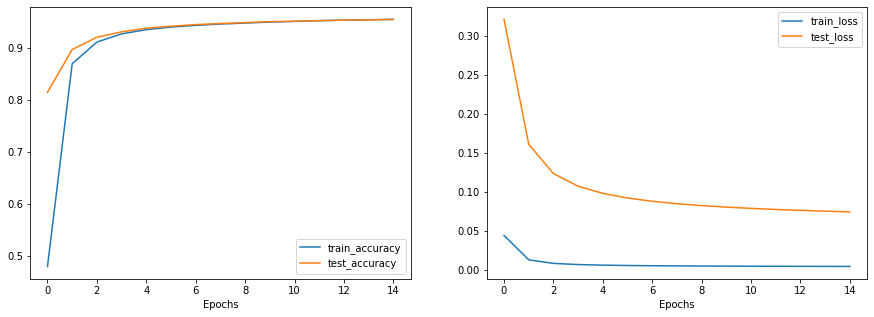

In [120]:
plot_log(log)

In [28]:
# Batch Size: 256

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001*0.1
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=256)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=256)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

log

Epoch 1:
	Train: Average Accuracy: 0.49531953170002885	Average Loss: 0.002627538884636795
	Test: Average Accuracy: 0.8166555304276315	Average Loss: 0.3187642084697194
Epoch 2:
	Train: Average Accuracy: 0.8701258505544356	Average Loss: 0.0007965188741334061
	Test: Average Accuracy: 0.8958539584387651	Average Loss: 0.16326045099173353
Epoch 3:
	Train: Average Accuracy: 0.9101858956473216	Average Loss: 0.0005102028572786415
	Test: Average Accuracy: 0.9191627656882592	Average Loss: 0.12480451762653717
Epoch 4:
	Train: Average Accuracy: 0.9266963835685484	Average Loss: 0.0003990036377980571
	Test: Average Accuracy: 0.9312304292130567	Average Loss: 0.10784007348687241
Epoch 5:
	Train: Average Accuracy: 0.9350891957085252	Average Loss: 0.00034245355421423445
	Test: Average Accuracy: 0.9379687104630566	Average Loss: 0.09838980705759107
Epoch 6:
	Train: Average Accuracy: 0.9405279062860024	Average Loss: 0.00030893175909013973
	Test: Average Accuracy: 0.9432909760880566	Average Loss: 0.092324241

{'test_accuracy': [0.8166555304276315,
  0.8958539584387651,
  0.9191627656882592,
  0.9312304292130567,
  0.9379687104630566,
  0.9432909760880566,
  0.9462694917130566,
  0.947833770875506,
  0.9492027375379555,
  0.9507652375379555,
  0.9521342042004048,
  0.9536967042004049,
  0.9545285614878543,
  0.9551633271128542,
  0.9555051239878543],
 'test_loss': [0.3187642084697194,
  0.16326045099173353,
  0.12480451762653717,
  0.10784007348687241,
  0.09838980705759107,
  0.09232424158440086,
  0.08809449544863039,
  0.08495466593468273,
  0.08251384318085334,
  0.0805488121499901,
  0.07891516909689762,
  0.07752898289005841,
  0.07632534027100121,
  0.07526419772846189,
  0.07430325256228812],
 'train_accuracy': [0.49531953170002885,
  0.8701258505544356,
  0.9101858956473216,
  0.9266963835685484,
  0.9350891957085252,
  0.9405279062860024,
  0.9443430817072294,
  0.9473503991755472,
  0.9493157312067971,
  0.9507461477534562,
  0.9520889211909562,
  0.9533118182063653,
  0.954129689

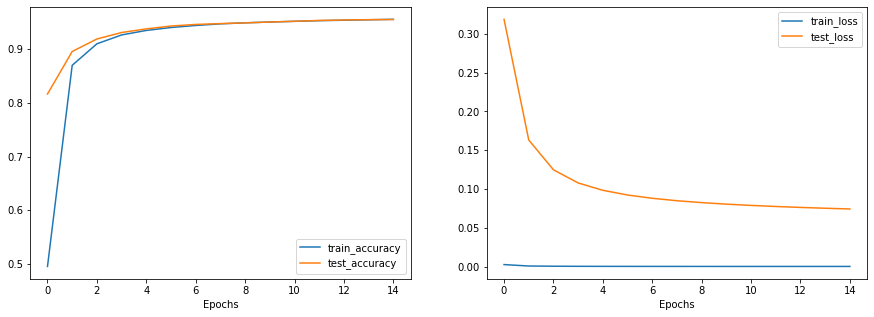

In [122]:
plot_log(log)

Small batch size means that we are giving a smaller group of data to the network each time. And this will lead to the fact that it will make the network update sooner for the next epoch.
Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error. Smaller batch sizes make it easier to fit one batch worth of training data in memory.
A large batch size means the model makes huge gradient updates.
The lack of generalization ability is because large batch methods tend to converge to sharp minimizers of the training function.

Using batch is that when you train your deep learning model without splitting the dataset into batches, your neural network has to store error values for all those data in the memory, which will cause a significant decrease in the speed of training.

The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model's internal parameters are updated. The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

Generally, Small batch sizes would make our algorithm run slower.
Since parallel computation is less for small batch sizes, it will take longer for the algorithm to finish. The downside of using a smaller batch size is that the model is not guaranteed to converge to the global optima.
On the other hand, in some cases, the neural network can converge better. This is intuitively explained by the fact that smaller batch sizes allow the model to start learning before seeing all the data.